In [1037]:
import os
import string
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


One time run script to create label folder for datasets

In [1038]:
# parent_dir = r'C:\Users\alpha\Projects\Doop Translator\datasets'

# for letter in string.ascii_uppercase:
#     valid_path = os.path.join(parent_dir, letter)
#     try:
#         os.makedirs(valid_path, exist_ok=True)
#         print(f"Folder '{letter}' created.")
#     except Exception as e:
#         print(f"Error creating folder '{letter}': {e}")

In [1039]:
path = r'C:\Users\alpha\Projects\Doop Translator\datasets'

In [1040]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64),
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=42
    )

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(64,64),
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    seed=42
    )

class_names = train_ds.class_names
class_names = ["." if n == 'DOT' else n for n in class_names]
print("Class names:", class_names) 

Found 837 files belonging to 27 classes.
Using 670 files for training.
Found 837 files belonging to 27 classes.
Using 167 files for validation.
Class names: ['A', 'B', 'C', 'D', '.', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [1041]:
train_ds = train_ds.map(lambda x,y: (x/255., y))
val_test_ds = val_test_ds.map(lambda x,y: (x/255., y))

In [1042]:
val_test_ds = val_test_ds.unbatch()
val_test_num = sum(1 for _ in val_test_ds)
left_size = val_test_num // 2
right_size = val_test_num - left_size
val_ds, test_ds = tf.keras.utils.split_dataset(val_test_ds, left_size=left_size, right_size=right_size, shuffle=True, seed=42)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

In [1043]:
def random_invert(image, label):
    if tf.random.uniform(()) > 0.5:  # 50% chance to invert
        image = 1 - image # Invert colors
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.014),
])

# Apply data augmentation only to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(random_invert)

In [1044]:
# for images, labels in train_ds.take(1):  # Take one batch
#     for i in range(9):  # Display 9 images
#         plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # Display grayscale images
#         plt.axis('off')
#     plt.show()


In [1045]:
# for image_batch, label_batch in train_ds.take(1):
#     plt.imshow(image_batch[0].numpy(), cmap='gray')
#     plt.title(label = f'Label: {class_names[label_batch[0]]}') 
#     plt.show()

In [1046]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Increase dropout to reduce overfitting
    tf.keras.layers.Dense(27)  # Output layer for 27 classes
])


In [1047]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [1048]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              loss=loss_fn,
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=early_stopping)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0671 - loss: 3.2431 - val_accuracy: 0.0964 - val_loss: 2.9880
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1035 - loss: 3.1389 - val_accuracy: 0.1084 - val_loss: 3.0184
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1389 - loss: 3.0692 - val_accuracy: 0.1084 - val_loss: 3.0079
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1014 - loss: 3.0702 - val_accuracy: 0.1446 - val_loss: 2.9564
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1624 - loss: 2.9622 - val_accuracy: 0.1687 - val_loss: 2.9289
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1716 - loss: 2.9868 - val_accuracy: 0.3133 - val_loss: 2.8147
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2737 - loss: 2.7478 - val_accuracy: 0.2530 - val_loss: 2.6917
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3066 - loss: 2.5729 - val_accuracy: 0.

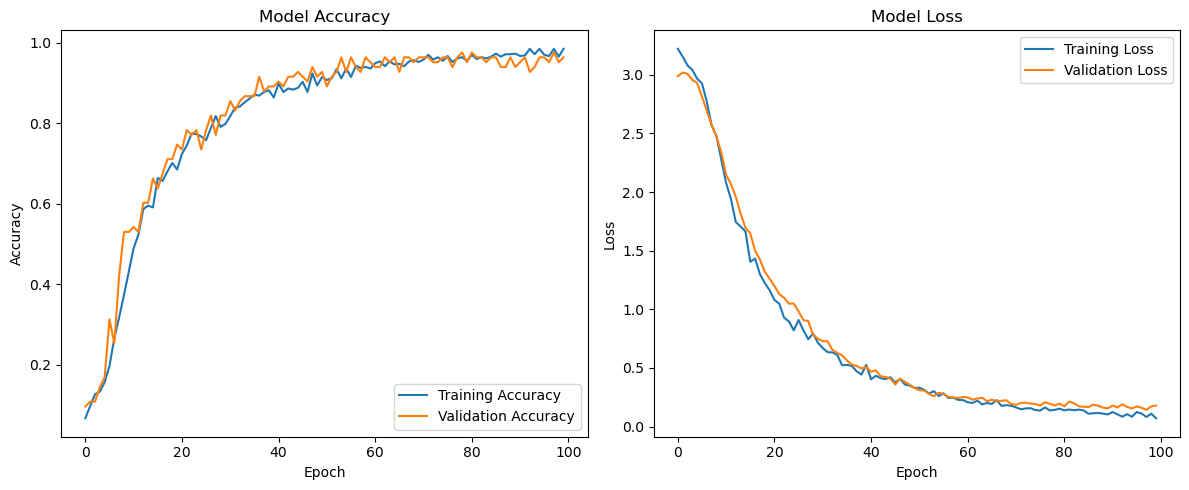

In [1056]:
history_dict = history.history
# print(history_dict.keys())

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [1050]:
loss, acc = model.evaluate(test_ds, verbose=2)

3/3 - 0s - 5ms/step - accuracy: 0.8690 - loss: 0.5987


In [1051]:
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 86.90%


In [1052]:
# Visualize test predictions 
# for image_batch, label_batch in test_ds:
#     predictions = model.predict(image_batch)
#     predicted_labels = tf.argmax(predictions, axis=1)
#     for i in range(len(image_batch)):
#         image = image_batch[i].numpy()
#         true_label = class_names[label_batch[i]]
#         pred_label = class_names[predicted_labels[i]]

#         plt.imshow(image, cmap='gray')
#         plt.title(label = f'True Label: {true_label}, Predicted Label: {pred_label}') 
#         plt.show()
    

In [1064]:
predict_path = r'C:\Users\alpha\Projects\Doop Translator\predict4'

prediction_ds = tf.keras.utils.image_dataset_from_directory(
    predict_path,
    labels=None,
    batch_size=32,
    image_size=(64,64),
    shuffle=False    
    )

prediction_ds = prediction_ds.map(lambda x: (x/255.))

Found 12 files.


In [1062]:
# Since training data did not account for different variations in color and contast and saturation of letters,
# preprocessing of prediction input is necessary to standardize output. i.e.  since letters were black on white background
# we need to preprocess input to match this.  We can try and data augment for this, but it may require many more epochs
# and this may end up with overfitting.

# def preprocess_for_prediction(image):
#     image = tf.image.rgb_to_grayscale(image)  
#     image = tf.image.adjust_contrast(image, -1) # invert contrast if needed
#     image = tf.image.grayscale_to_rgb(image) # this is needed to conform to training shape of (64,64,3), grayscale makes it (64,64,1)
#     return image

# prediction_ds = prediction_ds.map(preprocess_for_prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
tf.Tensor([19 21 18  6  9 14  7 19  9 14  2  5], shape=(12,), dtype=int64)
['S', 'U', 'R', 'F', 'I', 'N', 'G', 'S', 'I', 'N', 'C', 'E']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


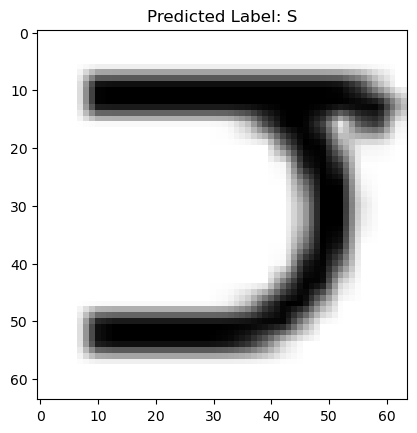

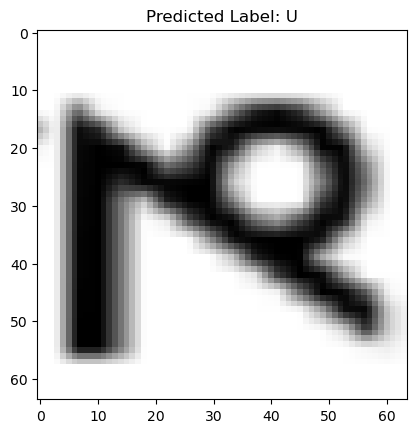

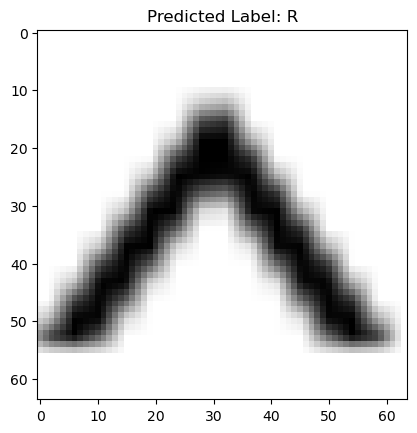

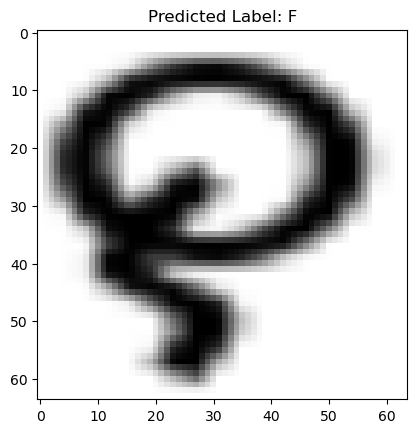

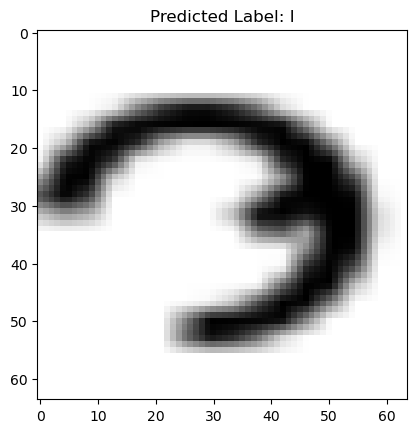

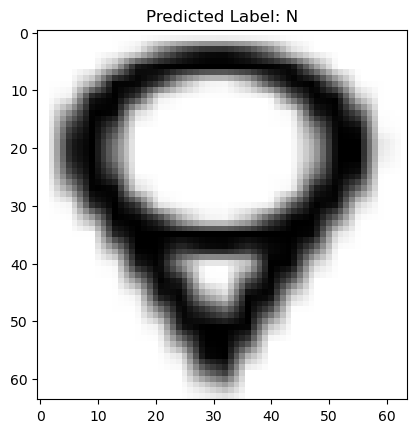

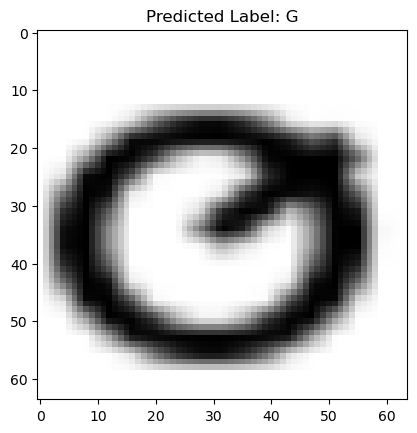

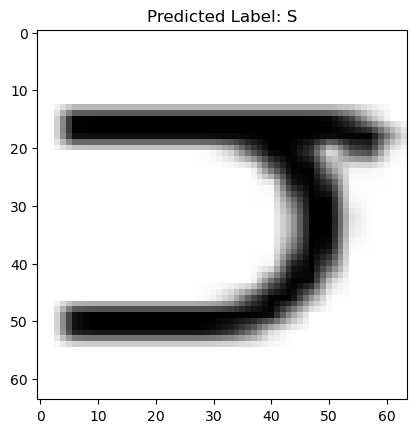

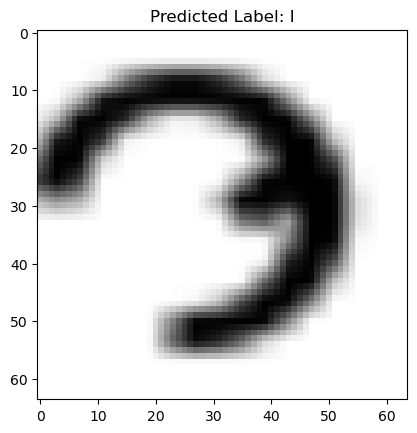

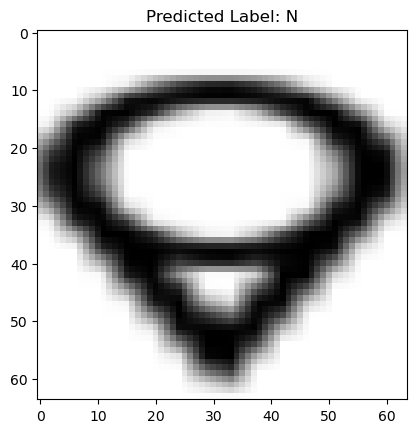

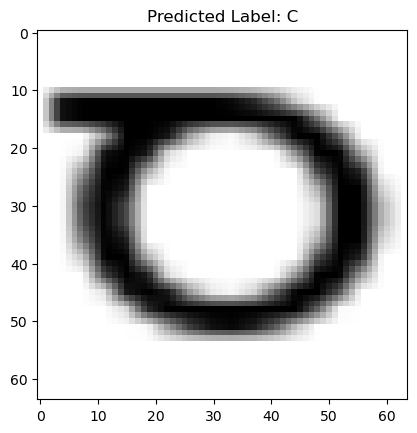

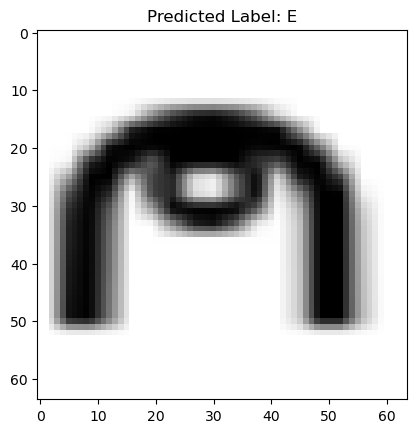

In [1065]:
predictions = model.predict(prediction_ds)
predicted_labels = tf.argmax(predictions, axis=1)
mapped_predicted_labels = [class_names[i] for i in predicted_labels]
print(predicted_labels)
print(mapped_predicted_labels)


for image_batch in prediction_ds:
    predictions = model.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1)
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()
        pred_label = class_names[predicted_labels[i]]
        plt.imshow(image, cmap='gray')
        plt.title(label = f'Predicted Label: {pred_label}') 
        plt.show()
    